**Initialize Dependencies**

In [4]:
import pickle # for pkl files
import matplotlib.pyplot as plt # for plotting
from tmaze_toolkit.data.extraction import selectDoorCoords, extractDoorTraces, initial_coords
from tmaze_toolkit.processing.signal import bandpass_filter, process_door_traces
from tmaze_toolkit.visualization.plotDoorTraces import plotDoorTraces
from tmaze_toolkit.data.openFunctions import openDoorTracesPkl
from tmaze_toolkit.processing.extractTrialTimes import clean_trial_events, extract_trial_times

In [5]:
pkl_file = r"N:\TMAZE\TMAZE_REFIND_VID_NEW\Cropped_ATO1_Vidoes\ATO1_2025-03-25T13_51_43_doorTraces.pkl"
dat = openDoorTracesPkl(pkl_file)


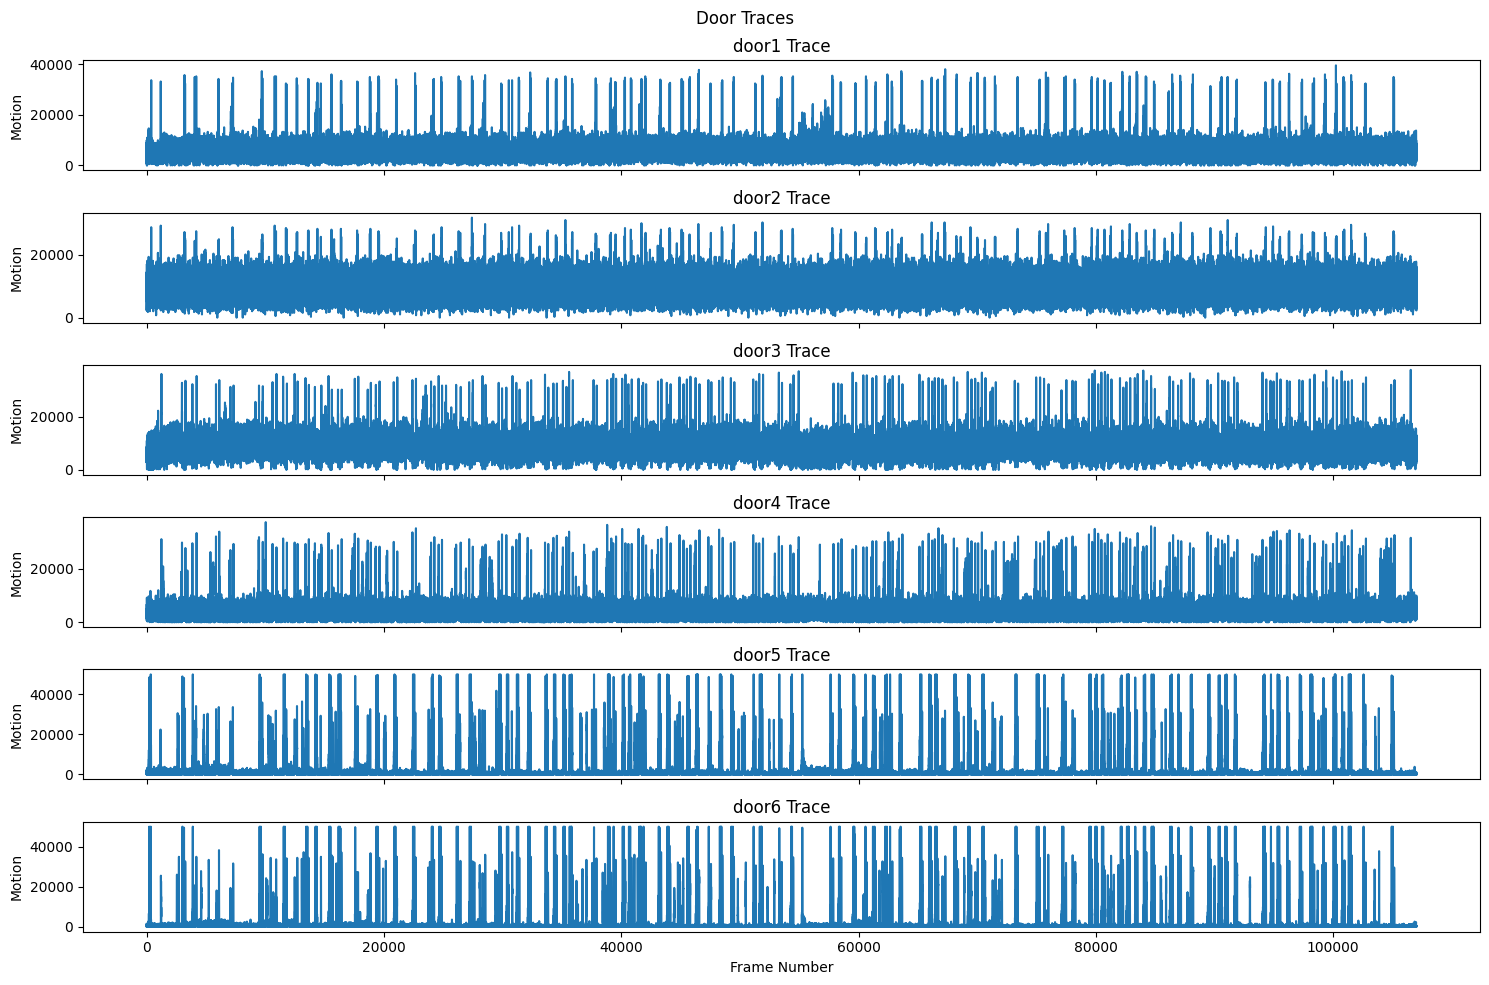

In [6]:
plotDoorTraces(dat)

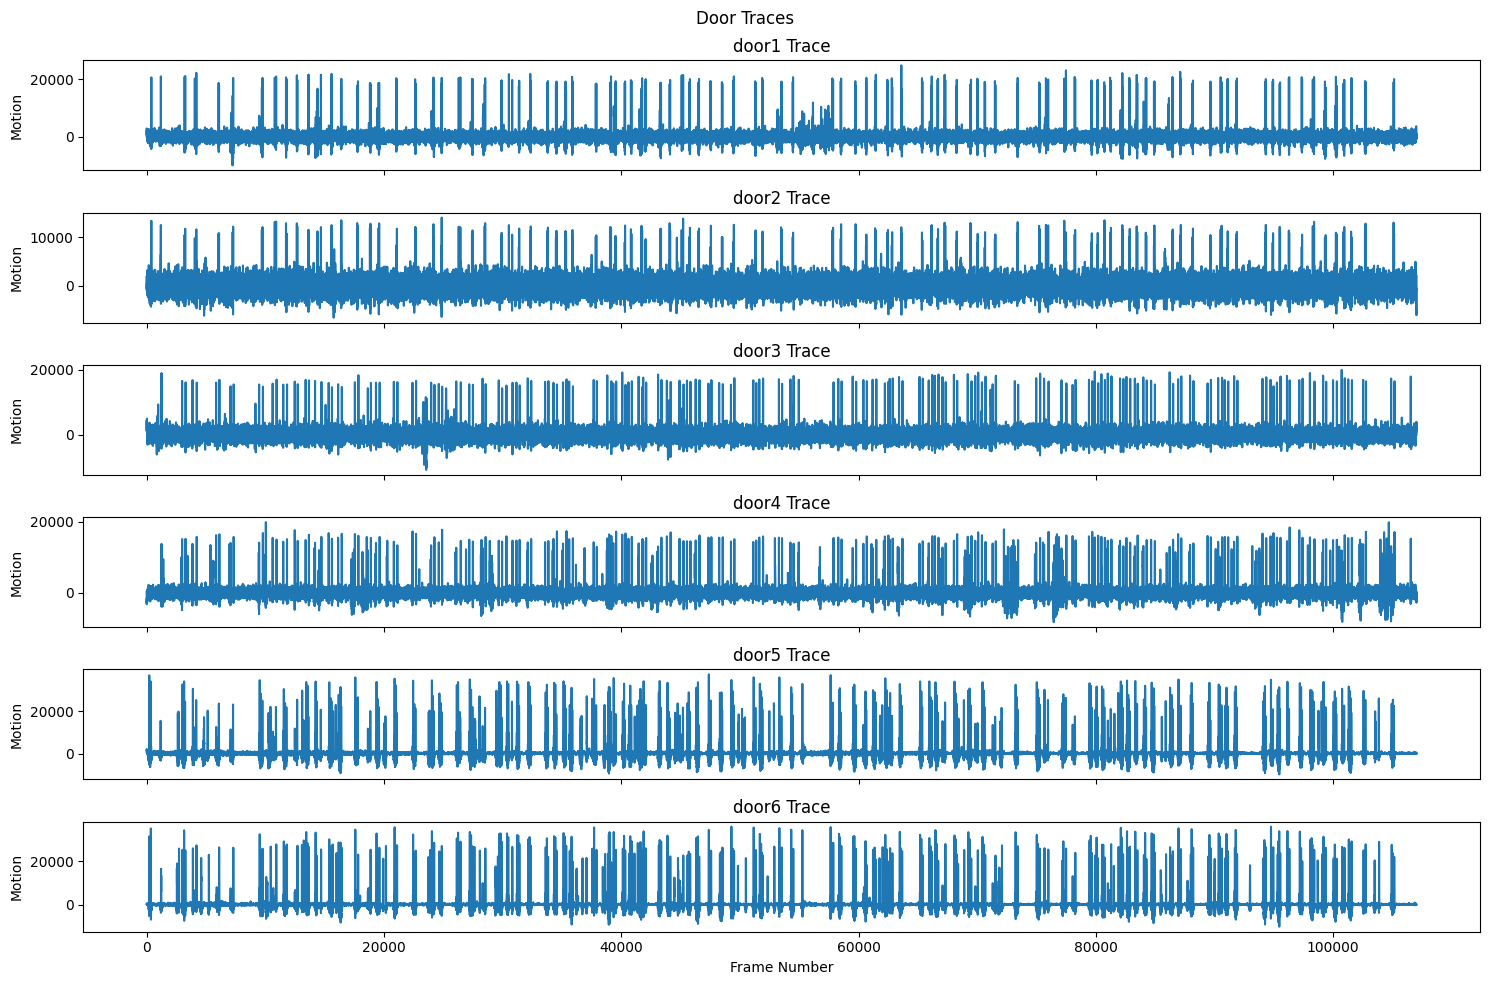

In [7]:
dat = bandpass_filter(dat)
plotDoorTraces(dat)

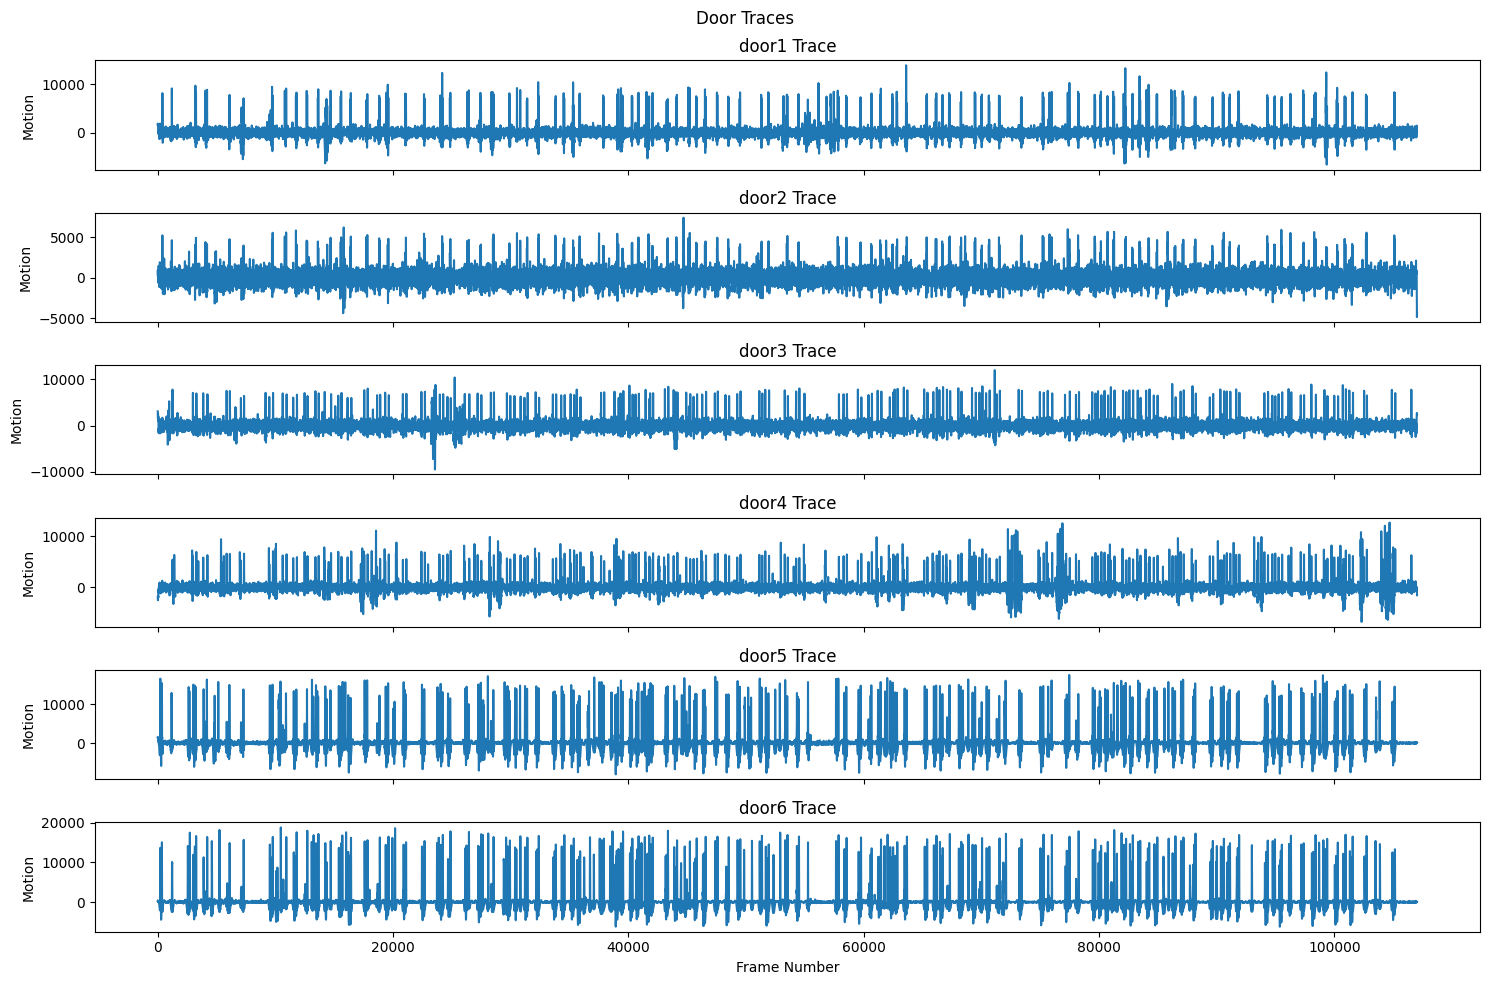

In [8]:
from scipy.ndimage import gaussian_filter1d # Smooth the door traces
for key in dat.keys():
    dat[key] = gaussian_filter1d(dat[key], sigma=5)

plotDoorTraces(dat)


Text(0.5, 0, 'Frame Number')

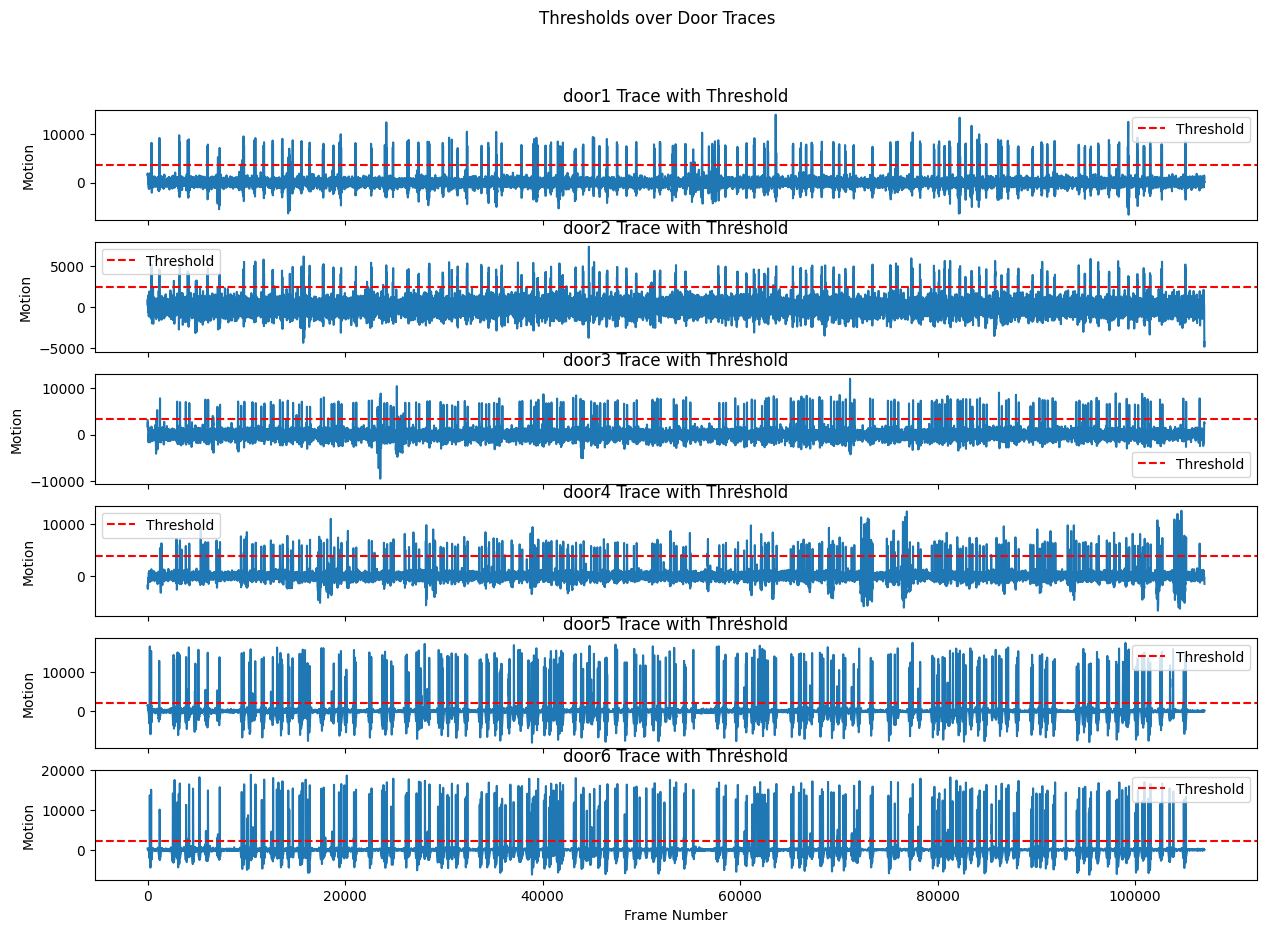

In [9]:
# Calculate thresholds based on statistics for each door
thresholds = {}
import numpy as np

for key in dat.keys():
    mean = np.mean(dat[key])
    std = np.std(dat[key])
    # Calculate mean and standard deviation of the trace
    if key == 'door5' or key == 'door6':
        n_std = .75 # This value can be adjusted to change sensitivity
    else:
        n_std = 2.5 # This value can be adjusted to change sensitivity
    #Set threshold as mean plus n standard deviations
    # Can adjust n to be more or less strict based on sensitivity needs
    
    thresholds[key] = mean + (n_std * std)

#Plot all thresholds over the traces

fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Thresholds over Door Traces')

for i, (door, trace) in enumerate(dat.items()):
    axs[i].plot(trace)
    axs[i].axhline(thresholds[door], color='r', linestyle='--', label='Threshold')
    axs[i].set_title(f'{door} Trace with Threshold')
    axs[i].set_ylabel('Motion')
    axs[i].legend()

axs[-1].set_xlabel('Frame Number')  

Text(0.5, 0, 'Frame Number')

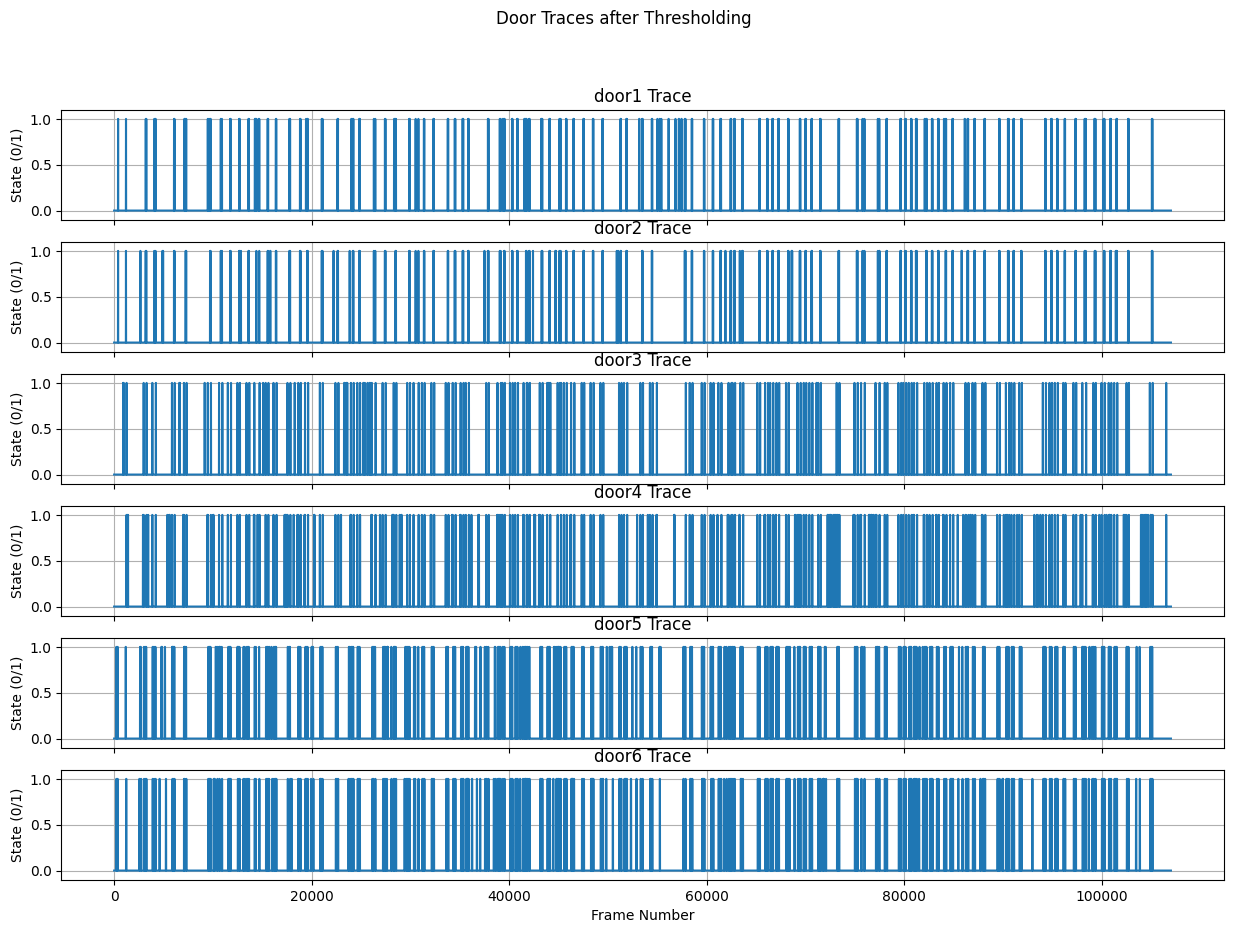

In [10]:
# Apply thresholds to all traces
for key in dat.keys():
    for i in range(len(dat[key])):
        if dat[key][i] > thresholds[key]:
            dat[key][i] = 1;
        else:
            dat[key][i] = 0;

# Plot all traces after thresholding

fig, axs = plt.subplots(6, 1, figsize=(15, 10), sharex=True)
fig.suptitle('Door Traces after Thresholding')

for i, (door, trace) in enumerate(dat.items()):
    axs[i].plot(trace)
    axs[i].set_title(f'{door} Trace')
    axs[i].set_ylabel('State (0/1)')
    axs[i].set_ylim(-0.1, 1.1)  # Set y-axis limits to better show binary data
    axs[i].grid(True)  # Add grid for better readability

axs[-1].set_xlabel('Frame Number')  

In [11]:
def pad_movement(floor, window_pad):
    for x in range(len(floor) - window_pad):
        if floor[x] == 1:
            # Search for the next 1 in the next window_pad frames
            for y in range(x + 1, x + window_pad):
                if floor[y] == 1:
                    # If a 1 is found, set all values in between to 1
                    for z in range(x + 1, y):
                        floor[z] = 1
                    break
    return floor
    


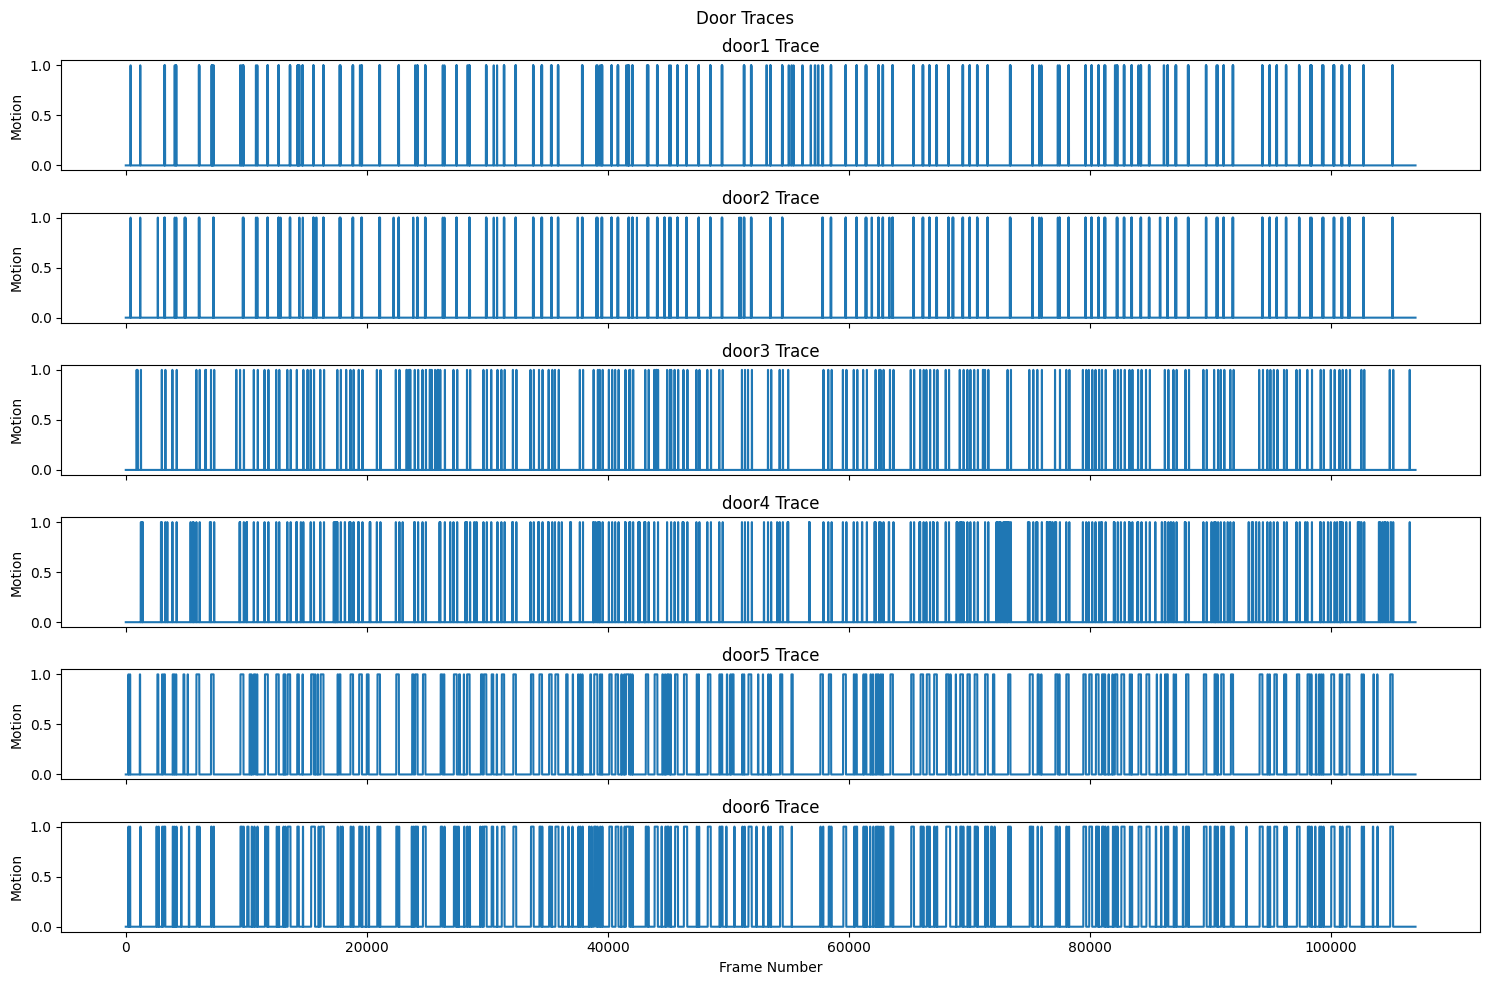

In [12]:
dat['door5'] = pad_movement(dat['door5'], 90)
dat['door6'] = pad_movement(dat['door6'], 90)

plotDoorTraces(dat)

In [13]:
fps = 30 #Frames per second of the video
window_frames = 15 #Window size to check for concurrent movement

import pandas as pd
def find_trial_events(trace1, trace2, window_frames):
    """
    Find distinct trial events when two doors move concurrently.
    
    Args:
        trace1 (list): First door trace (binary 0/1 values)
        trace2 (list): Second door trace (binary 0/1 values)
        window_frames (int): Window size to check for concurrent movement
        
    Returns:
        List of frame indices where distinct events start
    """
    events = []  # Store frame numbers where events start
    i = 0  # Initialize frame counter
    
    # Loop through the traces, stopping window_frames before the end to prevent overflow
    while i < len(trace1) - window_frames:
        # Get a slice of frames to check for concurrent movement
        window1 = trace1[i:i+window_frames]  # Window for first door
        window2 = trace2[i:i+window_frames]  # Window for second door
        
        # Check if both doors show any movement (1's) in their windows
        if 1 in window1 and 1 in window2:
            # If both doors moved, record the start frame of this window
            events.append(i)
            # Skip ahead by the window size to avoid detecting the same event multiple times
            i += window_frames
        else:
            # If no concurrent movement, check the next frame
            i += 1
            
    return events

# Detect trial starts (when doors 1 and 2 move together)
trial_starts = find_trial_events(dat['door1'], dat['door2'], window_frames)

# Detect trial ends (when doors 3 and 4 move together)
trial_ends = find_trial_events(dat['door3'], dat['door4'], window_frames)

# Print diagnostic information
print(f"Number of trial starts found: {len(trial_starts)}")
print(f"Number of trial ends found: {len(trial_ends)}")

print("\nTrial start frames:", trial_starts)
print("\nTrial end frames:", trial_ends)

# Handle mismatched numbers of starts and ends
# If we have 5 starts but only 4 ends, we'll only use the first 4 trials
min_trials = min(len(trial_starts), len(trial_ends))
matched_starts = trial_starts[:min_trials]  # Take only complete trials
matched_ends = trial_ends[:min_trials]      # Take only complete trials

# Create a pandas DataFrame to organize the trial information
trials_df = pd.DataFrame({
    'trial_start_frame': matched_starts,     # Frame numbers where trials begin
    'trial_end_frame': matched_ends,         # Frame numbers where trials end
    'trial_start_time': [frame/fps for frame in matched_starts],  # Convert frames to seconds
    'trial_end_time': [frame/fps for frame in matched_ends]       # Convert frames to seconds
})

# Display the final results
print("\nTrial timestamps (in seconds):")
print(trials_df)

# Some logic needs to be applied to clean this up. 
# A new trial cannot start until there is an end of the previous trial.
def clean_trial_events(starts, ends, window_frames):
    """
    Clean trial events to ensure proper sequencing (start -> end -> start -> end)
    
    Args:
        starts (list): Frame numbers of potential trial starts
        ends (list): Frame numbers of potential trial ends
        window_frames (int): Window size used for detection
        
    Returns:
        tuple: Lists of cleaned trial starts and ends
    """
    cleaned_starts = []
    cleaned_ends = []
    last_end = 0
    
    i, j = 0, 0  # Indices for starts and ends lists
    
    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]

        
        # If we find a valid start (after last end) and its corresponding end
        if current_start > last_end and current_end > current_start:
            cleaned_starts.append(current_start)
            cleaned_ends.append(current_end)
            last_end = current_end
            i += 1
            j += 1
        # Skip invalid starts (before last end)
        elif current_start <= last_end:
            i += 1
        # Skip ends that come before their start
        elif current_end <= current_start:
            j += 1

    while i < len(starts) and j < len(ends):
        current_start = starts[i]
        current_end = ends[j]
            
    return cleaned_starts, cleaned_ends

# Clean the trial events
cleaned_starts, cleaned_ends = clean_trial_events(trial_starts, trial_ends, window_frames)

# Create updated DataFrame with cleaned trials
cleaned_trials_df = pd.DataFrame({
    'trial_start_frame': cleaned_starts,
    'trial_end_frame': cleaned_ends,
    'trial_start_time': [frame/fps for frame in cleaned_starts],
    'trial_end_time': [frame/fps for frame in cleaned_ends],
    'trial_duration': [(end - start)/fps for start, end in zip(cleaned_starts, cleaned_ends)]
})

print("\nCleaned trial timestamps (in seconds):")
print(cleaned_trials_df)


Number of trial starts found: 398
Number of trial ends found: 390

Trial start frames: [377, 392, 1178, 1193, 3179, 3194, 3231, 3246, 4039, 4054, 4169, 4184, 6045, 6060, 6082, 6097, 7275, 7290, 9692, 9707, 9746, 9761, 10778, 10793, 10893, 10908, 11725, 11740, 11772, 11787, 12639, 12654, 12678, 12693, 13590, 13605, 13624, 13639, 14384, 14399, 14670, 14685, 15530, 15545, 15566, 15581, 16361, 16376, 16391, 16406, 17727, 17742, 17792, 17807, 18800, 18815, 18845, 18860, 19530, 19545, 19578, 19593, 21011, 21026, 21074, 21089, 22609, 22624, 22647, 22662, 24150, 24165, 24198, 24213, 24810, 24825, 24848, 24863, 26281, 26296, 26419, 26434, 27401, 27416, 27448, 27463, 28471, 28486, 28512, 28527, 29865, 29880, 29900, 29915, 30509, 30524, 30786, 30801, 31354, 31369, 31384, 31399, 32310, 32325, 32354, 32369, 33771, 33786, 33801, 33816, 34475, 34490, 34522, 34537, 35277, 35292, 35327, 35342, 35833, 35848, 35863, 35878, 37833, 37848, 37880, 37895, 39032, 39047, 39116, 39131, 39467, 39482, 39510, 39525

In [14]:
print(cleaned_trials_df)

    trial_start_frame  trial_end_frame  trial_start_time  trial_end_time  \
0                 377             1237         12.566667       41.233333   
1                3179             3264        105.966667      108.800000   
2                4039             4205        134.633333      140.166667   
3                6045             6112        201.500000      203.733333   
4                7275             7316        242.500000      243.866667   
..                ...              ...               ...             ...   
95             100210           100289       3340.333333     3342.966667   
96             100848           100953       3361.600000     3365.100000   
97             101488           101557       3382.933333     3385.233333   
98             102659           102743       3421.966667     3424.766667   
99             105069           105148       3502.300000     3504.933333   

    trial_duration  
0        28.666667  
1         2.833333  
2         5.533333  
3  

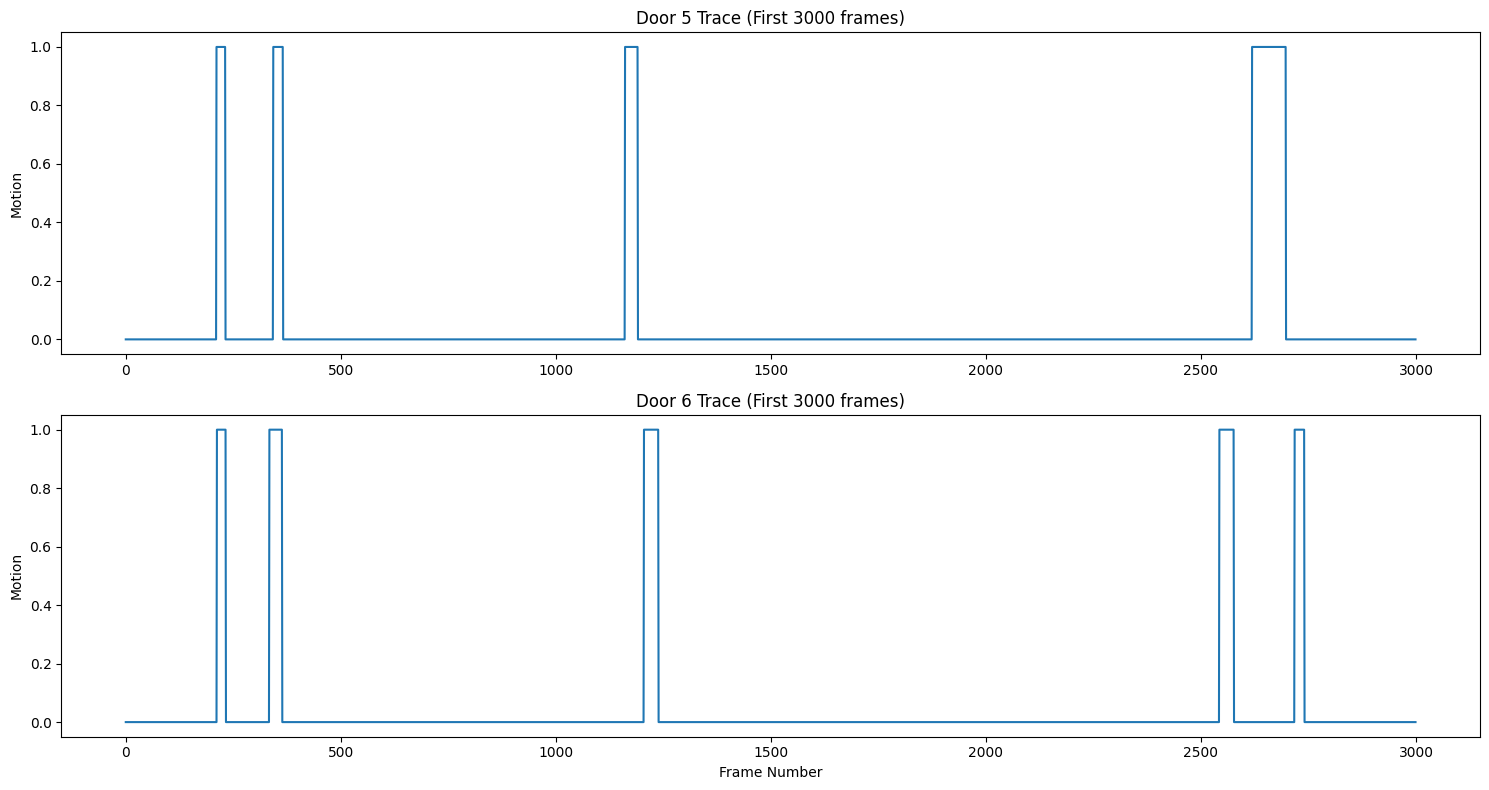

In [15]:
subset_data = {
    'door5': dat['door5'][:3000],
    'door6': dat['door6'][:3000]
}

# Plot just these two doors
plt.figure(figsize=(15, 8))

# Plot door5
plt.subplot(2, 1, 1)
plt.plot(subset_data['door5'])
plt.title('Door 5 Trace (First 3000 frames)')
plt.ylabel('Motion')

# Plot door6
plt.subplot(2, 1, 2)
plt.plot(subset_data['door6'])
plt.title('Door 6 Trace (First 3000 frames)')
plt.ylabel('Motion')
plt.xlabel('Frame Number')

plt.tight_layout()
plt.show()

In [16]:
def extract_floor_traces(dat):
    floor1 = dat['door5']
    floor2 = dat['door6']
    floor_traces = []

    # Add floor1 [x] to floor2 [x]
    for x in range(len(floor1)):
        floor_traces.append(floor1[x] + floor2[x])
    
    floor_starts = []
    floor_ends = []
    isMoving = False
    for x in range(len(floor_traces)):
        if floor_traces[x] == 2:
            if isMoving == False:
                floor_starts.append(x)
                isMoving = True
        if floor_traces[x] < 2:
            if isMoving == True:
                floor_ends.append(x)
                isMoving = False
    
    return floor_starts, floor_ends
floorStarts, floorEnds = extract_floor_traces(dat)

print(floorStarts)  
print(floorEnds)


[212, 343, 3014, 3147, 3891, 4044, 5893, 7073, 9514, 10659, 11550, 12522, 13435, 14228, 15380, 16172, 17576, 18648, 19365, 20881, 22444, 24013, 24657, 26131, 27225, 28314, 29714, 30358, 31200, 32157, 33617, 34323, 35125, 35647, 37700, 38866, 39355, 40117, 40642, 41503, 41874, 43148, 43879, 44915, 45575, 46311, 47371, 48295, 49270, 49401, 51151, 51667, 53313, 54292, 55252, 57635, 58330, 59541, 60443, 60575, 61207, 61338, 62242, 62376, 62648, 63444, 65171, 65946, 66465, 67074, 68069, 69238, 69834, 70432, 71298, 71444, 73213, 75005, 75658, 77143, 78037, 79453, 79944, 80501, 81002, 82071, 82607, 83309, 84033, 84688, 86241, 86371, 86953, 87971, 89451, 90341, 90891, 91697, 94082, 94746, 95302, 96130, 97175, 98074, 99174, 100021, 100738, 101301, 102549, 104917]
[232, 364, 3038, 3248, 3918, 4051, 6009, 7130, 9660, 10686, 11688, 12543, 13639, 14356, 15583, 16404, 17600, 18702, 19504, 20981, 22574, 24126, 24860, 26257, 27365, 28371, 29915, 30488, 31396, 32368, 33811, 34449, 35255, 35877, 37731, 

In [17]:
print(len(floorStarts))
print(len(floorEnds))

floors_trials_df = pd.DataFrame({
    'trial_start_frame': floorStarts,
    'trial_end_frame': floorEnds,
    'trial_start_time': [frame/fps for frame in floorStarts],
    'trial_end_time': [frame/fps for frame in floorEnds],
    'trial_duration': [(end - start)/fps for start, end in zip(floorStarts, floorEnds)]
})

print(floors_trials_df)

110
110
     trial_start_frame  trial_end_frame  trial_start_time  trial_end_time  \
0                  212              232          7.066667        7.733333   
1                  343              364         11.433333       12.133333   
2                 3014             3038        100.466667      101.266667   
3                 3147             3248        104.900000      108.266667   
4                 3891             3918        129.700000      130.600000   
..                 ...              ...               ...             ...   
105             100021           100267       3334.033333     3342.233333   
106             100738           100772       3357.933333     3359.066667   
107             101301           101531       3376.700000     3384.366667   
108             102549           102579       3418.300000     3419.300000   
109             104917           105123       3497.233333     3504.100000   

     trial_duration  
0          0.666667  
1          0.700000  
2

In [18]:
from tmaze_toolkit.visualization.videoTools import visualize_video_with_stamps

video_path = r"C:\Users\rlampre\Desktop\t-maze-Custer-Liu\Example Videos\BDY5_2024-07-01T19_24_56.mp4"
visualize_video_with_stamps(video_path, cleaned_trials_df)


Stamped video saved to C:\Users\rlampre\Desktop\t-maze-Custer-Liu\Example Videos\BDY5_2024-07-01T19_24_56_stamped.mp4


In [19]:
visualize_video_with_stamps(video_path, floors_trials_df)

KeyboardInterrupt: 

In [121]:
# compare cleaned_trials_df and floors_trials_df 
# find row numbers where trial_end_frame of floors_trials_df is not within 30 frames trial_start_frame of cleaned_trials_df

# find the row numbers where the difference between trial_end_frame and trial_start_frame is greater than 30
for i in range(len(floors_trials_df)):
    if abs(floors_trials_df['trial_end_frame'][i] - cleaned_trials_df['trial_start_frame'][i]) > 30:
        print(i)

print(cleaned_trials_df.shape)
print(floors_trials_df.shape)



(29, 5)
(29, 5)
